In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10

# Load the data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Input image dimensions.
input_shape = x_train.shape[1:]

Using TensorFlow backend.


In [2]:
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from model import LogGaussMF


def lenet_backend(input_shape):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(filters=6, kernel_size=5, activation="relu")(inputs)
    s2 = AveragePooling2D(pool_size=2)(c1)
    c3 = Conv2D(filters=16, kernel_size=5, activation="relu")(s2)
    s4 = AveragePooling2D(pool_size=2)(c3)
    c5 = Dense(120, activation="relu")(Flatten()(s4))
    return inputs, c5


model_type = "LeNet"

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = "%s_model.{epoch:03d}.h5" % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True)

inputs, c5 = lenet_backend(input_shape=input_shape)
f6 = Dense(84, activation="relu")(c5)
f7 = Dense(10, activation="softmax")(f6)
model = Model(inputs=inputs, outputs=f7)

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
__________

In [3]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)


datagen.fit(x_train)
batch_size = 32

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=60000 // batch_size,
    validation_data=(x_test, y_test),
    epochs=20, 
    verbose=1, 
    workers=4,
    callbacks=[checkpoint])

Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.6527 - acc: 0.4008 - val_loss: 1.4105 - val_acc: 0.4875

Epoch 00001: val_acc improved from -inf to 0.48750, saving model to /home/ryan-desktop/Documents/research-2019/cifar-10/saved_models/LeNet_model.001.h5
Epoch 2/20
1875/1875 [==============================] - 20s 10ms/step - loss: 1.4349 - acc: 0.4827 - val_loss: 1.3224 - val_acc: 0.5255

Epoch 00002: val_acc improved from 0.48750 to 0.52550, saving model to /home/ryan-desktop/Documents/research-2019/cifar-10/saved_models/LeNet_model.002.h5
Epoch 3/20
1875/1875 [==============================] - 19s 10ms/step - loss: 1.3534 - acc: 0.5164 - val_loss: 1.2635 - val_acc: 0.5464

Epoch 00003: val_acc improved from 0.52550 to 0.54640, saving model to /home/ryan-desktop/Documents/research-2019/cifar-10/saved_models/LeNet_model.003.h5
Epoch 4/20
1875/1875 [==============================] - 19s 10ms/step - loss: 1.2991 - acc: 0.5364 - val_loss: 1.2173 - val_acc

In [4]:
model_type = "Fuzzy-LeNet"

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = "%s_model.{epoch:03d}.h5" % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True)


inputs, c5 = lenet_backend(input_shape=input_shape)
memberships = LogGaussMF(10)(c5)
rules = Lambda(lambda x: K.sum(x, axis=-1))(memberships)
linear = Dense(10)(c5)
logits = Add()([rules, linear])
outputs = Activation("softmax")(logits)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 6)    456         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 14, 14, 6)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 10, 10, 16)   2416        average_pooling2d_3[0][0]        
__________________________________________________________________________________________________
average_po

In [5]:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)


datagen.fit(x_train)
batch_size = 32

fuzzy_history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=60000 // batch_size,
    validation_data=(x_test, y_test),
    epochs=20, 
    verbose=1, 
    workers=4,
    callbacks=[checkpoint])

Epoch 1/20
1875/1875 [==============================] - 18s 10ms/step - loss: 1.6359 - acc: 0.4083 - val_loss: 1.3696 - val_acc: 0.5180

Epoch 00001: val_acc improved from -inf to 0.51800, saving model to /home/ryan-desktop/Documents/research-2019/cifar-10/saved_models/Fuzzy-LeNet_model.001.h5
Epoch 2/20
1875/1875 [==============================] - 18s 10ms/step - loss: 1.3953 - acc: 0.5007 - val_loss: 1.2863 - val_acc: 0.5419

Epoch 00002: val_acc improved from 0.51800 to 0.54190, saving model to /home/ryan-desktop/Documents/research-2019/cifar-10/saved_models/Fuzzy-LeNet_model.002.h5
Epoch 3/20
1875/1875 [==============================] - 18s 9ms/step - loss: 1.2978 - acc: 0.5380 - val_loss: 1.2018 - val_acc: 0.5704

Epoch 00003: val_acc improved from 0.54190 to 0.57040, saving model to /home/ryan-desktop/Documents/research-2019/cifar-10/saved_models/Fuzzy-LeNet_model.003.h5
Epoch 4/20
1875/1875 [==============================] - 18s 10ms/step - loss: 1.2393 - acc: 0.5601 - val_loss:

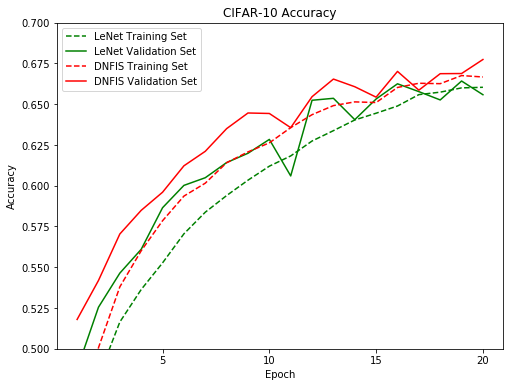

In [6]:
plt.figure(figsize=(8,6))

ax1, = plt.plot(history.history["acc"], "g--")
ax2, = plt.plot(history.history["val_acc"], "g")
ax3, = plt.plot(fuzzy_history.history["acc"], "r--")
ax4, = plt.plot(fuzzy_history.history["val_acc"], "r")

plt.title("CIFAR-10 Accuracy")

plt.xlabel("Epoch")
plt.xticks([4, 9, 14, 19], [5, 10, 15, 20])

plt.ylabel("Accuracy")
plt.ylim(0.5, 0.7)

plt.legend(
    [ax1, ax2, ax3, ax4],
    ["LeNet Training Set", 
     "LeNet Validation Set",
     "DNFIS Training Set",
     "DNFIS Validation Set"])

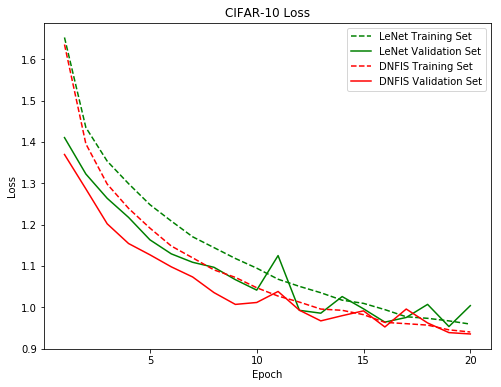

In [7]:
plt.figure(figsize=(8,6))

ax1, = plt.plot(history.history["loss"], "g--")
ax2, = plt.plot(history.history["val_loss"], "g")
ax3, = plt.plot(fuzzy_history.history["loss"], "r--")
ax4, = plt.plot(fuzzy_history.history["val_loss"], "r")

plt.title("CIFAR-10 Loss")

plt.xlabel("Epoch")
plt.xticks([4, 9, 14, 19], [5, 10, 15, 20])

plt.ylabel("Loss")

plt.legend(
    [ax1, ax2, ax3, ax4],
    ["LeNet Training Set", 
     "LeNet Validation Set",
     "DNFIS Training Set",
     "DNFIS Validation Set"])